In [1]:
# Propagate previous outputs to the current version
! cp -r  "/kaggle/input/simone-bertolotto-857533/estimators" "/kaggle/working/"
! cp -r  "/kaggle/input/simone-bertolotto-857533/learning_curves" "/kaggle/working/"
! cp -r  "/kaggle/input/simone-bertolotto-857533/solutions" "/kaggle/working/"
! cp -r  "/kaggle/input/simone-bertolotto-857533/embeddings" "/kaggle/working/"

cp: directory /kaggle/working does not exist
cp: directory /kaggle/working does not exist
cp: directory /kaggle/working does not exist
cp: directory /kaggle/working does not exist


In [2]:
# Workspace paths
from pathlib import Path

# Path to dirs
input_path = Path("../input")
working_path = Path(".")
temp_path = Path("../temp")

# Create some subdirs if don't exist
(working_path / "estimators").mkdir(exist_ok=True)
(working_path / "solutions").mkdir(exist_ok=True)
(working_path / "learning_curves").mkdir(exist_ok=True)
(working_path / "embeddings").mkdir(exist_ok=True)


# Import & utility functions

In [3]:
# ! python -m spacy download en_core_web_lg

In [4]:
from datetime import datetime
import re
import string
import time

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from tqdm import tqdm

from sklearn import set_config
from sklearn.calibration import CalibratedClassifierCV
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import (
    roc_auc_score,
    check_scoring,
    get_scorer,
    plot_roc_curve,
    roc_curve,
    auc,
    RocCurveDisplay,
)
from sklearn.model_selection import (
    GridSearchCV,
    learning_curve,
    train_test_split,
    cross_val_score,
)
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    Normalizer,
    Binarizer,
    MaxAbsScaler,
    StandardScaler,
    RobustScaler,
    QuantileTransformer,
    PowerTransformer,
)
from sklearn.svm import LinearSVC, SVC

import tensorflow as tf
import keras_tuner as kt  # complains about TPU

import en_core_web_lg


In [5]:
# set_config(display='diagram')      # draw html diagram for sklearn estimators
caches = joblib.Memory(temp_path)  # caches location for sklearn preprocessing

# GridSearchCV will be used a lot for validation, so here are the standard parmas used:
GS = {
    "n_jobs": -1,  # parallel execution on all the available cores
    "verbose": 10,  # help for backtracing
    "return_train_score": True,  # train_score are used for plotting validation curves
    "scoring": "roc_auc",  # it's a good metric for binary classification of unbalanced dateset
    "cv": 10,  # more fold reduce variance estimation of validation score
}

# convert python variable into a string, useful for estimators naming
def var2str(var):
    for key, value in globals().items():
        if id(value) == id(var):
            return key


Training (fit, in sklearn jargon) is a time consuming process, so the trained model shouldn't be lost.
The following custom `fit()` function always save the model. Moreover if there exist an already trained version in the
`./estimators` load it insted of train new model. This function is prefer over the scikit-learn standard 
`estimator.fit(X, y=None)` beacuse in `fit()` custom behaviors can be implemented such as:

- timing the fit process
- dinamically load pre-trained estimators
- automatic estimator saving
- automatic estimator naming
- automatic estimator versioning

In [6]:
def fit(estimator, X, y=None, load=True, save=True):

    # can't be ISO 8601 because has to be a valide filename
    now = datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
    name = var2str(estimator)

    # search for pre-trained estimators
    estimators = sorted((working_path / "estimators").glob(f"{name}_2021*.joblib"))
    print(f"FOUND\t{len(estimators)} {name} estimators")

    if load and estimators:
        estimator = joblib.load(estimators[-1])
        version = estimators[-1].stem.split("_")[-1]
        estimator.version = version
        estimator.name = name
        # TODO check that hyperparms are the same
        print(f"LOAD\t{estimators[-1]}")

    else:
        start_time = time.time()
        estimator.fit(X, y=y)
        estimator.version = now
        estimator.name = name
        elapsed_time = time.gmtime(time.time() - start_time)
        print(f"FIT\t{name} tooks {time.strftime('%X', elapsed_time)}")

        if save:
            path = working_path / "estimators" / f"{name}_{now}.joblib"
            joblib.dump(estimator, path)
            print(f"SAVE\t{name} to {path}")

    print()
    return estimator


Plots can give many insights about machine learning procedures. Here are some
plot function that will be used throughout the notebook:

- `plot_validation_curves`: how validation score changes with respect a single hyperparm
- `plot_validation_heatmaps`: how validation score changes with respect two hyperparms
- `plot_learning_curves`: how validation score changes with different number of training samples
- `plot_svd`: plot high dimensional vector in a 2D plane using SVD (Singular Value Decomposition)
- `plot_roc_curve`: plot ROC (Receiver Operating Characteristic) curve and add AUC (Area Under Curve) score to legend

In [7]:
def plot_mean_std(x, mean, std, logx=True, color="tab:orange", **kwargs):
    plot = plt.semilogx if logx else plt.plot
    plot(x, mean, color=color, **kwargs)
    plt.fill_between(x, mean - std, mean + std, color=color, alpha=0.2)


def plot_heatmap(x, y, score):
    plt.imshow(score, cmap=plt.cm.hot)
    max_y, max_x = np.unravel_index(score.argmax(), score.shape)
    plt.plot(max_x, max_y, "*", color="black")
    plt.colorbar()
    plt.xticks(np.arange(len(y)), y, rotation=45)
    plt.yticks(np.arange(len(x)), x)


def plot_validation_curves(estimator, param, **kwargs):
    cv = pd.DataFrame(estimator.cv_results_)
    score = estimator.best_score_
    x = cv[param].astype(np.float64)
    plt.figure(figsize=(14, 7))
    plt.title(f"Validation curves - {estimator.name}")
    plt.xlabel(param)
    plt.ylabel("Score")
    plot_mean_std(
        x,
        cv["mean_train_score"],
        cv["std_train_score"],
        label="TRAIN",
        linestyle="--",
        **kwargs,
    )
    plot_mean_std(
        x, cv["mean_test_score"], cv["std_test_score"], label="TEST", **kwargs
    )
    plt.axhline(score, color="grey", linestyle="dotted", label=f"{score:.5f}")
    plt.legend(loc="best")
    plt.show()


def plot_validation_heatmaps(estimator, param1, param2):
    cv = pd.DataFrame(estimator.cv_results_)
    x = [
        f"{j:.2}" if i % 2 == 0 else ""
        for i, j in enumerate(cv[param1].unique().astype(float))
    ]
    y = [
        f"{j:.2}" if i % 2 == 0 else ""
        for i, j in enumerate(cv[param2].unique().astype(float))
    ]
    train_score = cv.mean_train_score.values.reshape(len(x), len(y))
    test_score = cv.mean_test_score.values.reshape(len(y), len(x))

    plt.figure(figsize=(16, 5))
    plt.suptitle(f"Validation heatmaps - {estimator.name}")

    plt.subplot(1, 2, 1)
    plt.title(f"TRAIN - ★ {train_score.max():.5f}")
    plot_heatmap(x, y, train_score)
    plt.xlabel(param2)
    plt.ylabel(param1)

    plt.subplot(1, 2, 2)
    plt.title(f"TEST - ★ {test_score.max():.5f}")
    plot_heatmap(x, y, test_score)
    plt.xlabel(param2)
    plt.ylabel(param1)

    plt.show()


def plot_learning_curves(estimator, X, y, extrapolate=0, **kwargs):
    npy = working_path / "learning_curves" / f"{estimator.name}_{estimator.version}.npy"
    name = estimator.name

    if hasattr(estimator, "best_estimator_"):
        estimator = estimator.best_estimator_

    if npy.is_file():
        samples, train_mean, train_std, test_mean, test_std = np.load(npy)

    else:
        samples, train_scores, test_scores = learning_curve(
            estimator,
            X,
            y,
            scoring="roc_auc",
            train_sizes=np.linspace(0.1, 1.0, 10),
            n_jobs=-1,
            verbose=10,
            **kwargs,
        )
        train_mean, train_std = train_scores.mean(axis=1), train_scores.std(axis=1)
        test_mean, test_std = test_scores.mean(axis=1), test_scores.std(axis=1)
        np.save(npy, np.stack((samples, train_mean, train_std, test_mean, test_std)))

    plt.figure(figsize=(14, 7))
    plt.title(f"Learning curves - {name}")
    plt.xlabel("Samples")
    plt.ylabel("Score")
    plot_mean_std(
        samples,
        train_mean,
        train_std,
        logx=False,
        label="TRAIN",
        color="tab:blue",
        linestyle="--",
    )
    plot_mean_std(
        samples, test_mean, test_std, logx=False, label="TEST", color="tab:blue"
    )

    if extrapolate > samples[-1]:
        fit_samples = np.linspace(samples[0], extrapolate * 1.05, 20)

        def func(x, a, b, c):
            # Mazur, J.E., Hastie, R., 1978. Learning as accumulation: a reexamination
            # of the learning curve. Psychological Bulletin 85 (6), 1256e1274.
            return a * ((x + b) / (x + b + c))

        bounds = ([-np.inf, 1e-10, 1e-10], [np.inf, np.inf, np.inf])
        fit_params, _ = curve_fit(func, samples, test_mean, bounds=bounds)
        fit_scores = func(fit_samples, *fit_params)
        fit_score = func(extrapolate, *fit_params)
        plt.plot(fit_samples, fit_scores, linestyle="dotted", alpha=0.5)
        plt.plot(extrapolate, fit_score, "*", label=f"{fit_score:.5f}", color="orange")

    plt.legend(loc="best")
    plt.show()


def plot_svd(X, y, title="SVD"):
    X_svd = TruncatedSVD(2).fit_transform(X)
    color = ["tab:pink" if author else "tab:blue" for author in y]
    plt.scatter(X_svd[:, 0], X_svd[:, 1], marker=".", color=color, alpha=0.8)
    plt.title(title)


def plot_roc_curve(y_test, y_pred, ax, name=""):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    label = f"{name} (AUC = {roc_auc:0.5f})"
    RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax, name=label)


A simple function that takes an estimator and X_TEST data to produce a CSV file containing predictions (the one submitted to Kaggle).

In [8]:
def solution(estimator, data):
    """
    estimator: sklearn estimator used for prediction with `predict_proba` method
    data: test data in the format expected by the estimator
    """
    path = working_path / "solutions" / f"{estimator.name}_{estimator.version}.csv"
    if path.is_file():
        print(f"SOL. EXISTS AT \t{path}")
        return
    prediction = estimator.predict_proba(data)[:, 1]
    pd.DataFrame({"author": TEST_AUTHORS, "gender": prediction}).to_csv(
        path, index=False
    )
    print(f"SOL.\t{path}")


# Features extraction

In [9]:
# explicit type conversion ensure that all columns have the expected type

test_data = pd.read_csv(input_path / "datamining2021" / "test_data.csv").astype(
    {"author": str, "subreddit": str, "created_utc": int, "body": str}
)
train_data = pd.read_csv(input_path / "datamining2021" / "train_data.csv").astype(
    {"author": str, "subreddit": str, "created_utc": int, "body": str}
)
train_target = pd.read_csv(
    input_path / "datamining2021" / "train_target.csv", index_col="author", squeeze=True
)


In [10]:
Y = np.array([train_target[author] for author, _ in train_data.groupby("author")])
TEST_AUTHORS = sorted(test_data.author.unique())


Two are the important features avaiable in data that can help with the gender prediction: *subreddits* and *text* (text content of a commemnt). I grouped comments by user so I know what he/she wrote and on which subreddits; this give a more insights about user interested and beheavoiur.

In the following I'd like to eveluate the performance of the models before sending the result to kaggle and obtain the final score of the model. To do so a part of the TRAIN data is kept aside and used as test dataset. Here are the naming convention for datasets and models used throughtout the notebook:

- `S` and `T` in variables names refer to *subreddit* and *text* respectevily.
- *uppercase* data variables are objects that deal with all data available
- *lowercase* data variables are objects that deal with a part of data (e.g. train/test split)
- `X` in data variables means that it is a vectorized data, i.e. a matrix of numbers

Vectorized version of the whole `TRAIN` datasets will be used to train the final versions of models. `TEST` datasets are given to final version of model and obtain the predictions that will be sent to Kaggle.

`X_train` and `X_test` will be used to train and test models inside the notebook. If the obtained test score is sufficiently high, the model will be consider sucessful and will be trained on the whole dataset (`X_TRAIN`) and prediction of `X_TEST` will be sent to Kaggle.

The reason to used two different vectorizer (`VECTORIZER` and `vectorizer`) is to avoide "`test` dataset contamination". Infact if the vectorizer is fit on the whole data could contains some information about `test` data, an undesiderable circunstance.

Some observations of arguments of `train_test_split`:
- `random_state` has to be the same beteewn S-split and T-split otherwise these two features cannot be combined in a model (different author are selected for train and test).
- `stratify` is important when dealing with unbalanced dataset, it ensure the same unbalanced in the train and in the test datasets.

# Feature - Subreddits


In [11]:
def subreddits(data):
    return [group.subreddit.str.cat(sep=" ") for _, group in data.groupby("author")]


S_TRAIN = subreddits(train_data)
S_TEST = subreddits(test_data)

# Vectorization of ALL TEST and TRAIN data.
S_VECTORIZER = CountVectorizer(dtype="int", lowercase=False)
S_X_TRAIN = S_VECTORIZER.fit_transform(S_TRAIN)
S_X_TEST = S_VECTORIZER.transform(S_TEST)

# Split TRAIN in train and test. test will be used to evaluate the performance.
S_train, S_test, y_train, y_test = train_test_split(
    S_TRAIN, Y, test_size=0.20, random_state=42, stratify=Y
)

# Vectorization of test and train data.
S_vectorizer = CountVectorizer(dtype="int", lowercase=False)
S_X_train = S_vectorizer.fit_transform(S_train)
S_X_test = S_vectorizer.transform(S_test)



*Subreddits* feature can give some insights about users interests; if a user leave a comment on a particular subreddit, he/she is probably interested about that topic. Before feeding a model with data, some preprocessing is required. There are users that wrote hundreds of comments while others just wrote a couple. The purpose of preprocessing is to rescale these differents quantities so the models can yield better predictions.

Six differents types of preprocessing are performed, then the result are passed to a `TruncatedSVD` estimator that squashes high-dimentional features space (number of different subreddits) into a 2d plane. The plots shows that different preprocessing tecniques produce different results. The goal is to separate the blue dots from the pink ones in other to make the life easier for the classifier.

FOUND	1 S_quantile_uniform estimators
LOAD	estimators/S_quantile_uniform_2021-08-23T13-13-20.joblib

FOUND	1 S_quantile_normal estimators
LOAD	estimators/S_quantile_normal_2021-08-23T13-13-52.joblib



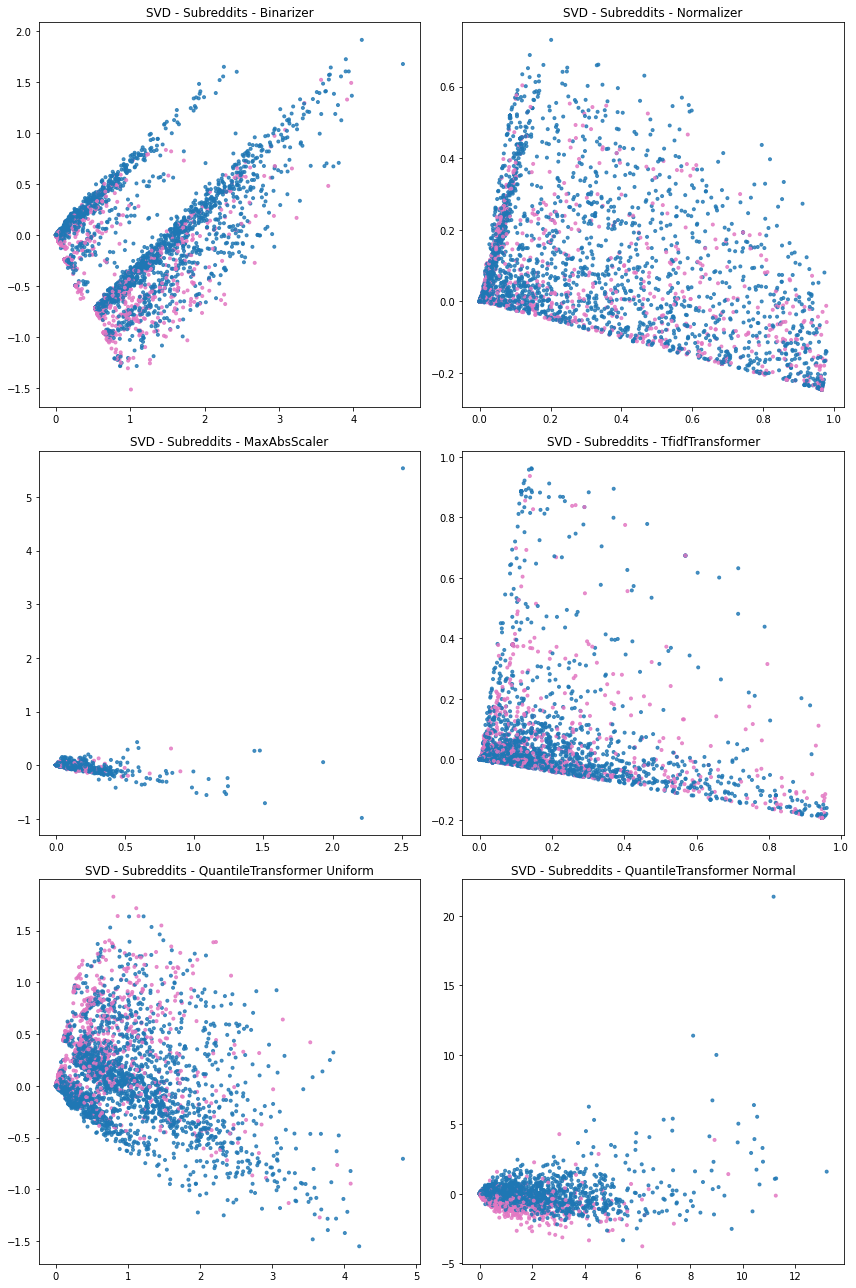

In [12]:
S_quantile_uniform = QuantileTransformer(output_distribution="uniform")
S_quantile_uniform = fit(S_quantile_uniform, S_X_train)
S_quantile_normal = QuantileTransformer(output_distribution="normal")
S_quantile_normal = fit(S_quantile_normal, S_X_train)

names = [
    "Binarizer",
    "Normalizer",
    "MaxAbsScaler",
    "TfidfTransformer",
    "QuantileTransformer Uniform",
    "QuantileTransformer Normal",
]

preprocessors = [
    Binarizer().fit_transform(S_X_train),
    Normalizer().fit_transform(S_X_train),
    MaxAbsScaler().fit_transform(S_X_train),
    TfidfTransformer().fit_transform(S_X_train),
    S_quantile_uniform.transform(S_X_train),
    S_quantile_normal.transform(S_X_train),
]

plt.figure(figsize=(12, 18))
for i, (name, preprocessor) in enumerate(zip(names, preprocessors)):
    plt.subplot(3, 2, i + 1)
    plot_svd(preprocessor, y_train, title=f"SVD - Subreddits - {name}")

plt.tight_layout()
plt.show()


In this notebook I will experimenting with two types of preprocessing:
- `Binarizer`: 1 if user leave a comment on that suberddit otherwise 0. It's simple and computationally fast.
- `QuantileTransformer Normal`: it's a non-linear transformation. It's quite computationally expensive.

---

## Models

Different models are tried for classification based on subreddits. They are defined using the concept of `Pipeline` that allow to concatenate subsequantial transformations and the classification is done in the last step of the pipeline. The pipeline is nested in a `GridSearchCV` for hyperparms optimization.

Here is the convention for models naming:
- `S_` or `T_`: on which feature the model is trained on: subreddits or text.
- `_preprocessing_`: various preprocessing steps
- `_classifier`: the classification model at the end of the pipeline.
- `_final`: if the model is trained on the whole dataset and used for kaggle evaluation



*example:*
`S_binarizer_svm_linear` is a model trained on `S_X_train` (not the whole training dataset) that perform "binarization“ followed by a Linear SVD classfication.


### Linear SVM

Linear SVM are succesful models for classification that rely on solid mathematical foundation. Here this model is tested with *binarizer* and *quantile* preprocessing. The hyperparam is only one `C` (proportional to the inverse of regularization) and the best value is determined by cross-validation (to be precise sklearn implements `StratifiedKFold` so each fold is unbalanced as the origianl dataset).

In [13]:
S_binarizer_svm_linear = GridSearchCV(
    Pipeline(
        [
            ("binarizer", Binarizer()),
            (
                "svm_linear",
                LinearSVC(
                    class_weight="balanced",  # account for class imbalance
                    random_state=42,  # repeatability of results
                    max_iter=5000,  # increased for solution convergence
                ),
            ),
        ],
        memory=caches,
    ),
    {
        "svm_linear__C": np.logspace(-2, 1, 200),  # logspace for hyperparam interval
    },
    **GS
)

S_binarizer_svm_linear = fit(S_binarizer_svm_linear, S_X_train, y_train)
S_binarizer_svm_linear


FOUND	1 S_binarizer_svm_linear estimators
LOAD	estimators/S_binarizer_svm_linear_2021-08-23T13-14-29.joblib



GridSearchCV(cv=10,
             estimator=Pipeline(memory=Memory(location=temp),
                                steps=[('binarizer', Binarizer()),
                                       ('svm_linear',
                                        LinearSVC(class_weight='balanced',
                                                  max_iter=5000,
                                                  random_state=42))]),
             n_jobs=-1,
             param_grid={'svm_linear__C': array([ 0.01      ,  0.01035322,  0.01071891,  0.01109752,  0.01148951,
        0.01189534,  0.01231551,  0.01275051,  0.01320088,  0.01366716,
        0.01414991,  0.014649...
        3.65438307,  3.78346262,  3.91710149,  4.05546074,  4.19870708,
        4.34701316,  4.50055768,  4.65952567,  4.8241087 ,  4.99450512,
        5.17092024,  5.35356668,  5.54266452,  5.73844165,  5.94113398,
        6.15098579,  6.36824994,  6.59318827,  6.82607183,  7.06718127,
        7.31680714,  7.57525026,  7.84282206,  8.119844

`GridSearchCV` gives us data about hyperparsms optimization for free that can be used to construct different plots. When there is just one hyperparam `plot_validation_curves` shows how TRAIN and TEST scores change for different value of the hyperparam. The higher validation score is highlighted by a gray dotted line. This type of plot are called `Validation plot`


Learning curves show how much the performance can improve if the model is fitted with different number of training samples. The whole training dataset contains 5000 samples, 4000 are in S_X_train and 1000 in S_X_test. Sample in S_X_train are used for draw learning curves and TEST score is calculated with 5-fold cross-validation. I used `scipy.optimize.curve_fit` to fit TRAIN score and try to predict the score for the model trained on the whole dataset (5000 sample, orange star ★).


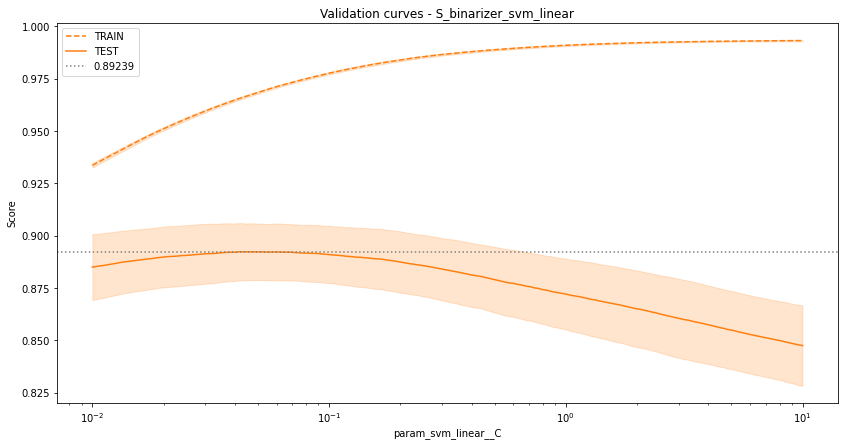

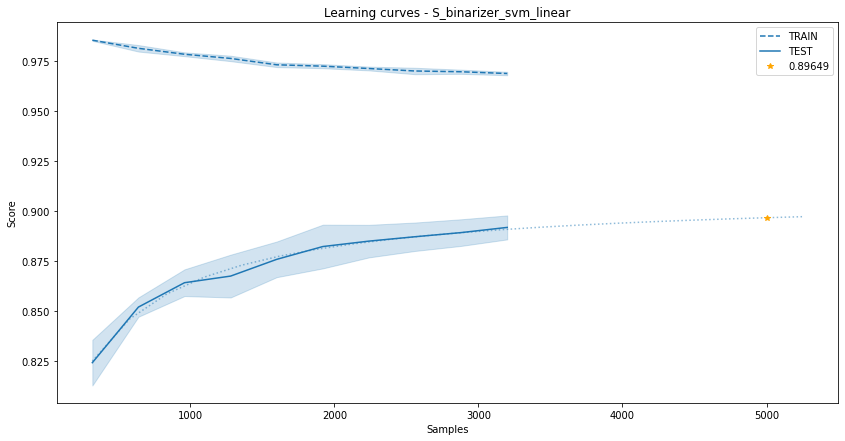

In [14]:
plot_validation_curves(S_binarizer_svm_linear, 'param_svm_linear__C')
plot_learning_curves(S_binarizer_svm_linear, S_X_train, y_train, len(train_target))

`LinearSVC` is implemented with *liblinear* (a library for large linear classification) which scales better than *libsvm* (the library used in `SVC`). The drawback is that *liblinear* does not have a built in probability estimation but a similar result can be obtain using `CalibratedClassifierCV`. After the fit, `S_calibrated_binarizer_svm_linear` is now equipped with `predict_proba` method.

In [15]:
S_calibrated_binarizer_svm_linear = CalibratedClassifierCV(
    S_binarizer_svm_linear.best_estimator_, cv=10
)
S_calibrated_binarizer_svm_linear = fit(
    S_calibrated_binarizer_svm_linear, S_X_train, y_train
)
S_calibrated_binarizer_svm_linear


FOUND	1 S_calibrated_binarizer_svm_linear estimators
LOAD	estimators/S_calibrated_binarizer_svm_linear_2021-08-23T13-15-18.joblib



CalibratedClassifierCV(base_estimator=Pipeline(memory=Memory(location=temp),
                                               steps=[('binarizer',
                                                       Binarizer()),
                                                      ('svm_linear',
                                                       LinearSVC(C=0.04768611697714469,
                                                                 class_weight='balanced',
                                                                 max_iter=5000,
                                                                 random_state=42))]),
                       cv=10)

In [16]:
S_quantile_normal_svm_linear = GridSearchCV(
    Pipeline(
        [
            ("quantile", QuantileTransformer(output_distribution="normal")),
            ("svm_linear", LinearSVC(class_weight="balanced", random_state=42)),
        ],
        memory=caches,
    ),
    {
        "svm_linear__C": np.logspace(-4, -1, 200),
    },
    **GS
)

S_quantile_normal_svm_linear = fit(S_quantile_normal_svm_linear, S_X_train, y_train)
S_quantile_normal_svm_linear


FOUND	1 S_quantile_normal_svm_linear estimators
LOAD	estimators/S_quantile_normal_svm_linear_2021-08-23T13-15-18.joblib



GridSearchCV(cv=10,
             estimator=Pipeline(memory=Memory(location=temp),
                                steps=[('quantile',
                                        QuantileTransformer(output_distribution='normal')),
                                       ('svm_linear',
                                        LinearSVC(class_weight='balanced',
                                                  random_state=42))]),
             n_jobs=-1,
             param_grid={'svm_linear__C': array([0.0001    , 0.00010353, 0.00010719, 0.00011098, 0.0001149 ,
       0.00011895, 0.00012316, 0.00012751, 0.00013201, 0.0001...
       0.03654383, 0.03783463, 0.03917101, 0.04055461, 0.04198707,
       0.04347013, 0.04500558, 0.04659526, 0.04824109, 0.04994505,
       0.0517092 , 0.05353567, 0.05542665, 0.05738442, 0.05941134,
       0.06150986, 0.0636825 , 0.06593188, 0.06826072, 0.07067181,
       0.07316807, 0.0757525 , 0.07842822, 0.08119845, 0.08406653,
       0.08703591, 0.09011018, 0.09329304

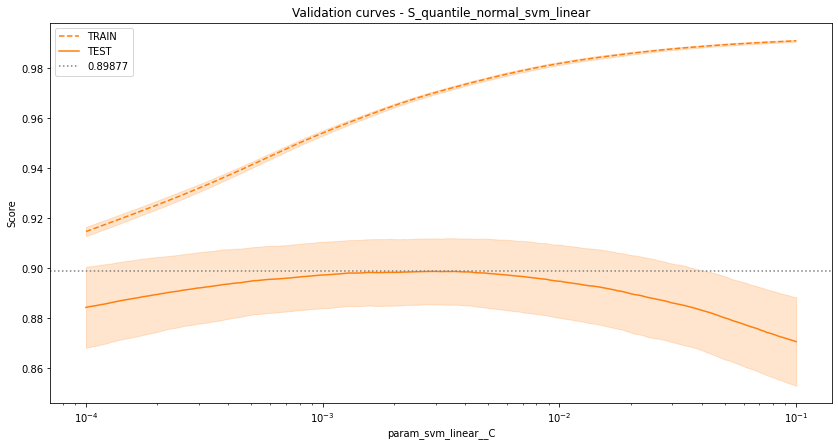

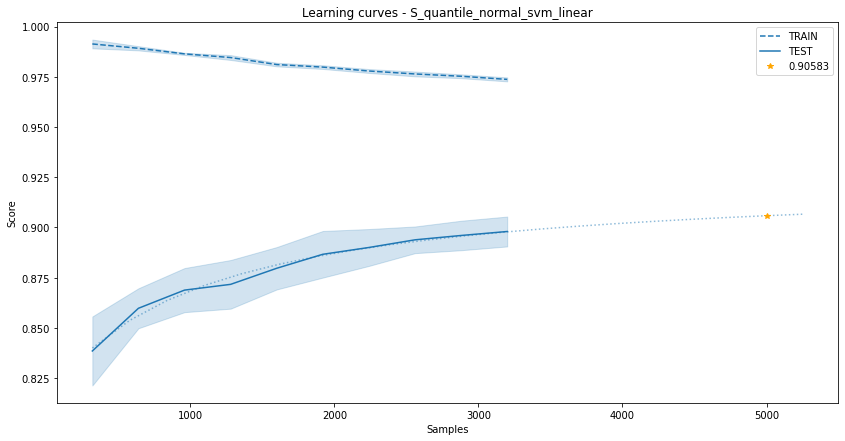

In [17]:
plot_validation_curves(S_quantile_normal_svm_linear, 'param_svm_linear__C')
plot_learning_curves(S_quantile_normal_svm_linear, S_X_train, y_train, len(train_target))

In [18]:
S_calibrated_quantile_normal_svm_linear = CalibratedClassifierCV(
    S_quantile_normal_svm_linear.best_estimator_, cv=10
)
S_calibrated_quantile_normal_svm_linear = fit(
    S_calibrated_quantile_normal_svm_linear, S_X_train, y_train
)
S_calibrated_quantile_normal_svm_linear


FOUND	1 S_calibrated_quantile_normal_svm_linear estimators
LOAD	estimators/S_calibrated_quantile_normal_svm_linear_2021-08-23T14-28-31.joblib



CalibratedClassifierCV(base_estimator=Pipeline(memory=Memory(location=temp),
                                               steps=[('quantile',
                                                       QuantileTransformer(output_distribution='normal')),
                                                      ('svm_linear',
                                                       LinearSVC(C=0.003570785964900463,
                                                                 class_weight='balanced',
                                                                 random_state=42))]),
                       cv=10)

### Non-Linear SVM

TODO wrote aboute kernel trick

In [19]:
S_binarizer_svm_rbf = GridSearchCV(
    Pipeline(
        [
            ("binarizer", Binarizer()),
            (
                "svm_rbf",
                SVC(
                    kernel="rbf",  # non-linear kernel
                    class_weight="balanced",
                    random_state=42,
                    probability=True,  # built probability estimation
                    cache_size=2000,  # kernel cache, faster traning
                ),
            ),
        ],
        memory=caches,
    ),
    {
        "svm_rbf__C": np.logspace(-2, 2, 20),  # prop to inverse of regularization
        "svm_rbf__gamma": np.logspace(-3, 1, 20),  # rbf param
    },
    **GS
)

S_binarizer_svm_rbf = fit(S_binarizer_svm_rbf, S_X_train, y_train)
S_binarizer_svm_rbf


FOUND	1 S_binarizer_svm_rbf estimators
LOAD	estimators/S_binarizer_svm_rbf_2021-08-23T15-22-54.joblib



GridSearchCV(cv=10,
             estimator=Pipeline(memory=Memory(location=../temp),
                                steps=[('binarizer', Binarizer()),
                                       ('svm_rbf',
                                        SVC(cache_size=2000,
                                            class_weight='balanced',
                                            probability=True,
                                            random_state=42))]),
             n_jobs=-1,
             param_grid={'svm_rbf__C': array([1.00000000e-02, 1.62377674e-02, 2.63665090e-02, 4.28133240e-02,
       6.95192796e-02, 1.12883789e-01, 1.83298071e-01, 2.976351...
                         'svm_rbf__gamma': array([1.00000000e-03, 1.62377674e-03, 2.63665090e-03, 4.28133240e-03,
       6.95192796e-03, 1.12883789e-02, 1.83298071e-02, 2.97635144e-02,
       4.83293024e-02, 7.84759970e-02, 1.27427499e-01, 2.06913808e-01,
       3.35981829e-01, 5.45559478e-01, 8.85866790e-01, 1.43844989e+00,
       2.335

There are two hyperparmas in the svm rbf model and the model must be optimize for both. A simple 1d-curve is no more sufficient to rappresent how scores variation during GridSearchCV. The GridSearchCV result are organized in a heatmap plot.

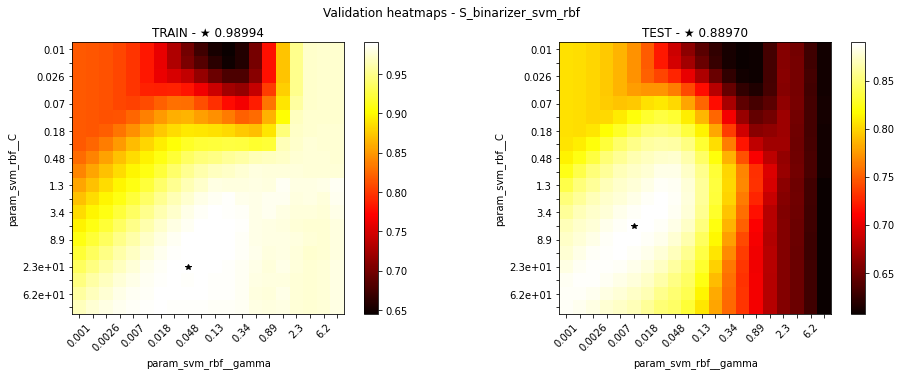

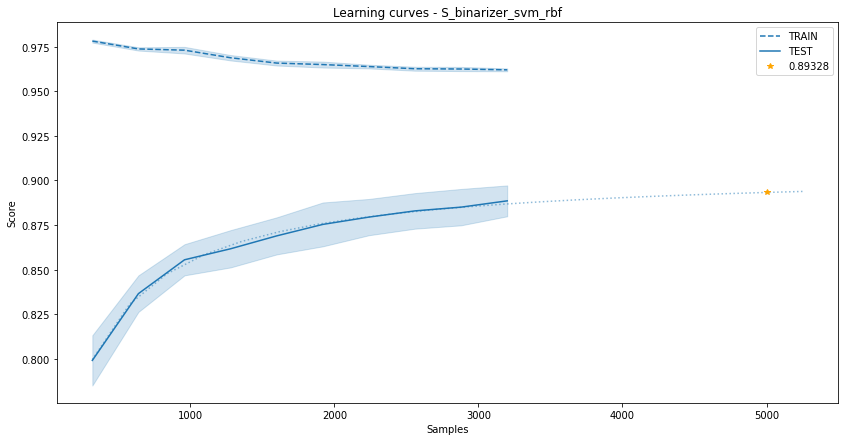

In [20]:
plot_validation_heatmaps(
    S_binarizer_svm_rbf, "param_svm_rbf__C", "param_svm_rbf__gamma"
)
plot_learning_curves(S_binarizer_svm_rbf, S_X_train, y_train, len(train_target))


In [21]:
S_quantile_normal_svm_rbf = GridSearchCV(
    Pipeline(
        [
            ("quantile", QuantileTransformer(output_distribution="normal")),
            (
                "svm_rbf",
                SVC(
                    kernel="rbf",
                    class_weight="balanced",
                    random_state=42,
                    probability=True,
                    cache_size=2000,
                ),
            ),
        ],
        memory=caches,
    ),
    {
        "svm_rbf__C": np.logspace(-2, 2, 20),
        "svm_rbf__gamma": np.logspace(-4, 0, 20),
    },
    **GS
)

S_quantile_normal_svm_rbf = fit(S_quantile_normal_svm_rbf, S_X_train, y_train)
S_quantile_normal_svm_rbf


FOUND	1 S_quantile_normal_svm_rbf estimators
LOAD	estimators/S_quantile_normal_svm_rbf_2021-08-24T12-35-23.joblib



GridSearchCV(cv=10,
             estimator=Pipeline(memory=Memory(location=../temp),
                                steps=[('quantile',
                                        QuantileTransformer(output_distribution='normal')),
                                       ('svm_rbf',
                                        SVC(cache_size=2000,
                                            class_weight='balanced',
                                            probability=True,
                                            random_state=42))]),
             n_jobs=-1,
             param_grid={'svm_rbf__C': array([1.00000000e-02, 1.62377674e-02, 2.63665090e-02, 4.28133240e-02,
       6.95192796e-02, 1...
                         'svm_rbf__gamma': array([1.00000000e-04, 1.62377674e-04, 2.63665090e-04, 4.28133240e-04,
       6.95192796e-04, 1.12883789e-03, 1.83298071e-03, 2.97635144e-03,
       4.83293024e-03, 7.84759970e-03, 1.27427499e-02, 2.06913808e-02,
       3.35981829e-02, 5.45559478e-02, 8.8586

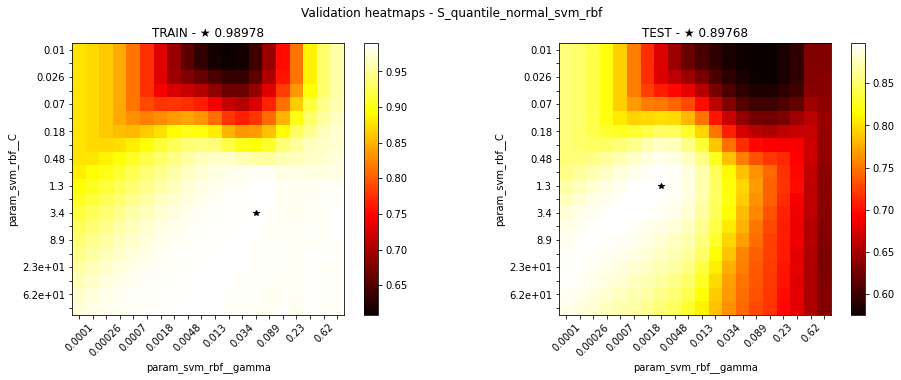

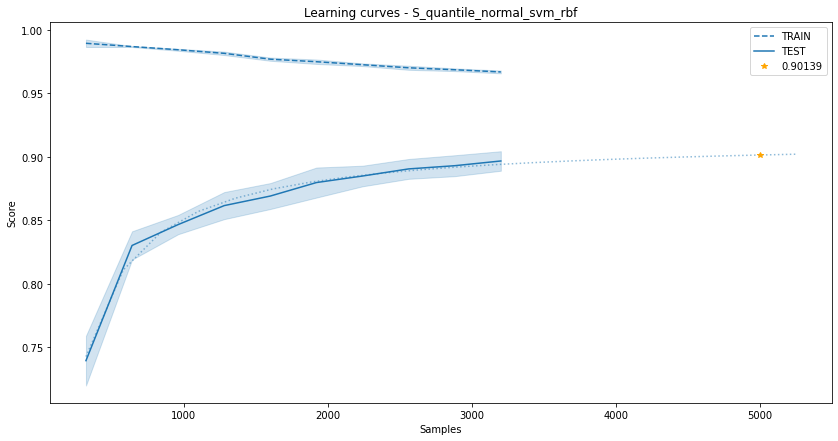

In [22]:
plot_validation_heatmaps(
    S_quantile_normal_svm_rbf, "param_svm_rbf__C", "param_svm_rbf__gamma"
)
plot_learning_curves(S_quantile_normal_svm_rbf, S_X_train, y_train, len(train_target))


### Naive Bayes

Naive Bayes models leverage the power of Bayes theorem and built upon it. Two type of Naive Bayes model are explored: `ComplementNB` and `BernoulliNB`. BernoulliNB is designed for binary features so the preprocessing step is `Binarizer`. ComplementNB is a modification of MultinomialNB optimized for unbalanced dataset.

In [23]:
S_binarizer_complement_nb = GridSearchCV(
    Pipeline(
        [
            ("binarizer", Binarizer()),
            ("complement_nb", ComplementNB()),
        ],
        memory=caches,
    ),
    {
        "complement_nb__alpha": np.logspace(-3, 3, 500),
    },
    **GS
)

S_binarizer_complement_nb = fit(S_binarizer_complement_nb, S_X_train, y_train)
S_binarizer_complement_nb


FOUND	1 S_binarizer_complement_nb estimators
LOAD	estimators/S_binarizer_complement_nb_2021-08-25T08-58-28.joblib



GridSearchCV(cv=10,
             estimator=Pipeline(memory=Memory(location=../temp),
                                steps=[('binarizer', Binarizer()),
                                       ('complement_nb', ComplementNB())]),
             n_jobs=-1,
             param_grid={'complement_nb__alpha': array([1.00000000e-03, 1.02807322e-03, 1.05693455e-03, 1.08660611e-03,
       1.11711065e-03, 1.14847155e-03, 1.18071285e-03, 1.21385926e-03,
       1.24793621e-03, 1.28296980e-03, 1.31898690...
       5.90939590e+02, 6.07529169e+02, 6.24584471e+02, 6.42118571e+02,
       6.60144909e+02, 6.78677305e+02, 6.97729965e+02, 7.17317494e+02,
       7.37454909e+02, 7.58157646e+02, 7.79441575e+02, 8.01323013e+02,
       8.23818733e+02, 8.46945981e+02, 8.70722485e+02, 8.95166472e+02,
       9.20296681e+02, 9.46132376e+02, 9.72693362e+02, 1.00000000e+03])},
             return_train_score=True, scoring='roc_auc', verbose=10)

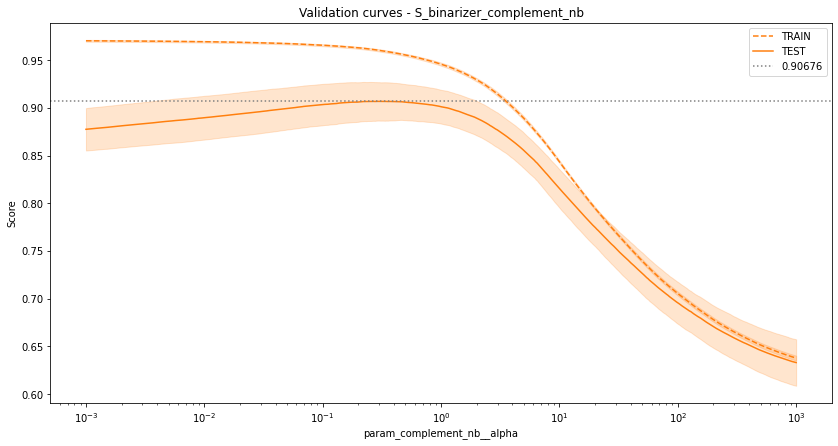

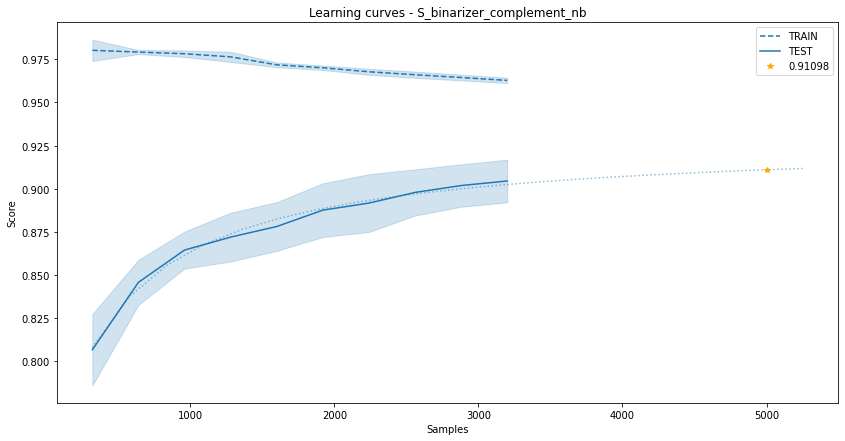

In [24]:
plot_validation_curves(S_binarizer_complement_nb, "param_complement_nb__alpha")
plot_learning_curves(S_binarizer_complement_nb, S_X_train, y_train, len(train_target))


In [25]:
S_binarizer_bernoulli_nb = GridSearchCV(
    Pipeline(
        [
            ("binarizer", Binarizer()),
            ("bernoulli_nb", BernoulliNB()),
        ],
        memory=caches,
    ),
    {
        "bernoulli_nb__alpha": np.logspace(-3, 3, 500),
    },
    **GS
)

S_binarizer_bernoulli_nb = fit(S_binarizer_bernoulli_nb, S_X_train, y_train)
S_binarizer_bernoulli_nb


FOUND	1 S_binarizer_bernoulli_nb estimators
LOAD	estimators/S_binarizer_bernoulli_nb_2021-08-25T08-59-00.joblib



GridSearchCV(cv=10,
             estimator=Pipeline(memory=Memory(location=../temp),
                                steps=[('binarizer', Binarizer()),
                                       ('bernoulli_nb', BernoulliNB())]),
             n_jobs=-1,
             param_grid={'bernoulli_nb__alpha': array([1.00000000e-03, 1.02807322e-03, 1.05693455e-03, 1.08660611e-03,
       1.11711065e-03, 1.14847155e-03, 1.18071285e-03, 1.21385926e-03,
       1.24793621e-03, 1.28296980e-03, 1.31898690e-0...
       5.90939590e+02, 6.07529169e+02, 6.24584471e+02, 6.42118571e+02,
       6.60144909e+02, 6.78677305e+02, 6.97729965e+02, 7.17317494e+02,
       7.37454909e+02, 7.58157646e+02, 7.79441575e+02, 8.01323013e+02,
       8.23818733e+02, 8.46945981e+02, 8.70722485e+02, 8.95166472e+02,
       9.20296681e+02, 9.46132376e+02, 9.72693362e+02, 1.00000000e+03])},
             return_train_score=True, scoring='roc_auc', verbose=10)

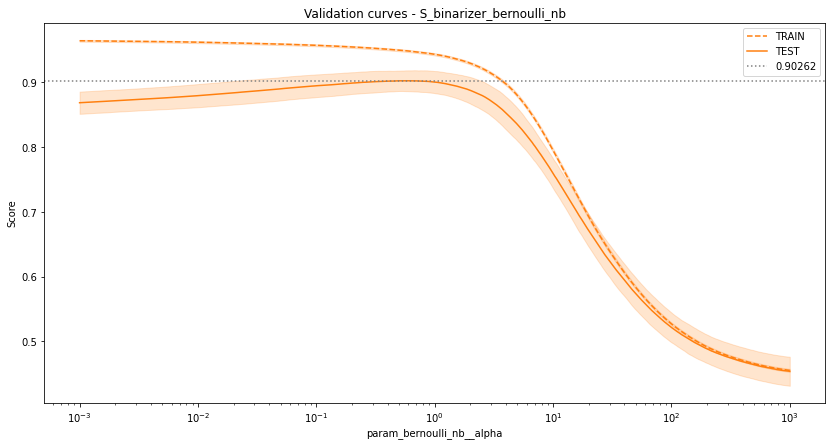

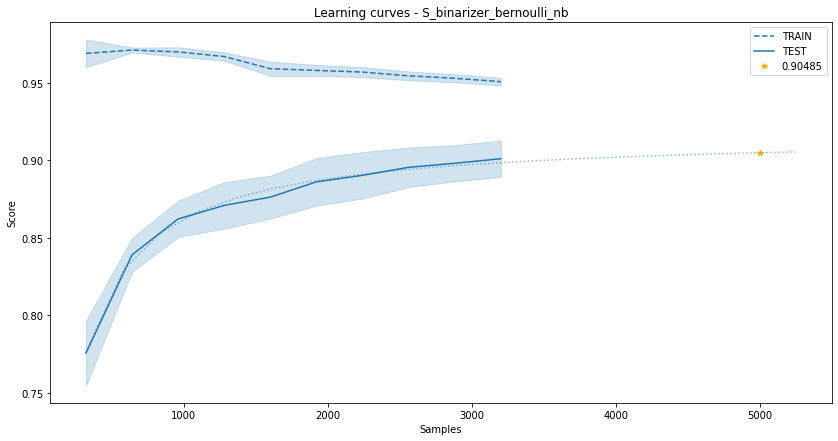

In [26]:
plot_validation_curves(S_binarizer_bernoulli_nb, "param_bernoulli_nb__alpha")
plot_learning_curves(S_binarizer_bernoulli_nb, S_X_train, y_train, len(train_target))


### Multi Layer Perceptron

In [27]:
S_binarizer_svd_mlp = GridSearchCV(
    Pipeline(
        [
            ("binarizer", Binarizer()),
            ("svd", TruncatedSVD(n_components=1500)),
            ("mlp", MLPClassifier(max_iter=500, random_state=42)),
        ],
        memory=caches,
    ),
    {
        "mlp__alpha": np.logspace(-3, 2, 30),
    },
    **GS
)

S_binarizer_svd_mlp = fit(S_binarizer_svd_mlp, S_X_train, y_train)
S_binarizer_svd_mlp


FOUND	1 S_binarizer_svd_mlp estimators
LOAD	estimators/S_binarizer_svd_mlp_2021-08-25T10-38-44.joblib



GridSearchCV(cv=10,
             estimator=Pipeline(memory=Memory(location=../temp),
                                steps=[('binarizer', Binarizer()),
                                       ('svd', TruncatedSVD(n_components=1500)),
                                       ('mlp',
                                        MLPClassifier(max_iter=500,
                                                      random_state=42))]),
             n_jobs=-1,
             param_grid={'mlp__alpha': array([1.00000000e-03, 1.48735211e-03, 2.21221629e-03, 3.29034456e-03,
       4.89390092e-03, 7.27895384e-03, 1.08263673e-02, 1.6102...
       2.39502662e-02, 3.56224789e-02, 5.29831691e-02, 7.88046282e-02,
       1.17210230e-01, 1.74332882e-01, 2.59294380e-01, 3.85662042e-01,
       5.73615251e-01, 8.53167852e-01, 1.26896100e+00, 1.88739182e+00,
       2.80721620e+00, 4.17531894e+00, 6.21016942e+00, 9.23670857e+00,
       1.37382380e+01, 2.04335972e+01, 3.03919538e+01, 4.52035366e+01,
       6.72335754e+01, 

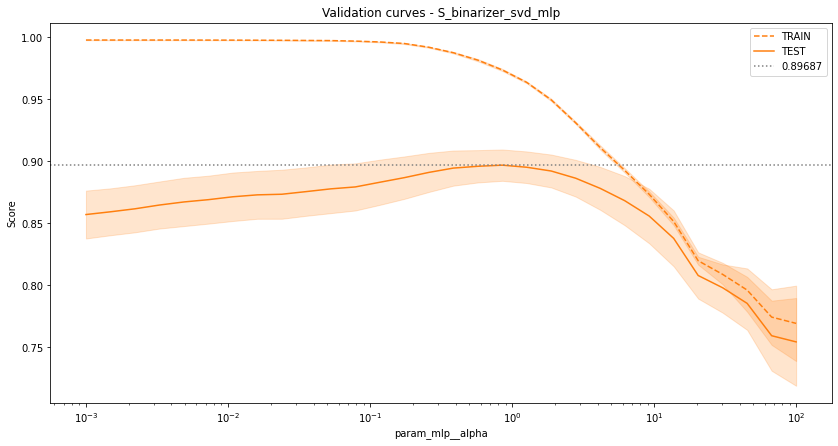

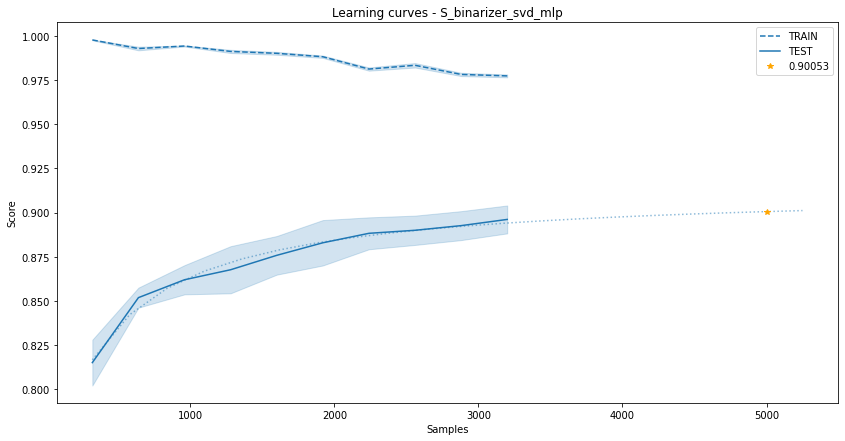

In [28]:
plot_validation_curves(S_binarizer_svd_mlp, "param_mlp__alpha")
plot_learning_curves(S_binarizer_svd_mlp, S_X_train, y_train, len(train_target))


Multi Layer Perceptron seems to yield good predictions so it make sense (litteary) to go deeper. The previous `MLPClassifier` consists of only one hidden layer with 100 neurons. As suggested by sklearn docs, there are other libraries to experimenting with more complex Neural Nets model; one of them is *Keras*, a frendly API on top in tensorflow. For hyperparms optimization will be used `keras_tuner`.

In [29]:
def hypermodel(hp):

    inputs = tf.keras.Input(shape=(S_X_train.shape[1],))
    x = tf.keras.layers.Dense(hp.Choice("units_1", [32, 64, 128]), activation="relu")(
        inputs
    )
    x = tf.keras.layers.Dropout(hp.Float("dropout_1", 0, 0.5))(x)
    x = tf.keras.layers.Dense(hp.Choice("units_2", [16, 32, 64]), activation="relu")(x)
    x = tf.keras.layers.Dropout(hp.Float("dropout_2", 0, 0.5))(x)
    x = tf.keras.layers.Dense(hp.Choice("units_3", [8, 16, 32]), activation="relu")(x)
    x = tf.keras.layers.Dropout(hp.Float("dropout_3", 0, 0.5))(x)
    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[],
        optimizer=tf.keras.optimizers.Adam(
            hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
        ),
    )

    return model


tuner = kt.Hyperband(
    hypermodel,
    kt.Objective("val_roc_auc", direction="max"),
    max_epochs=10,
    directory="estimators",
    project_name="S_binarizer_neural_net",
)

tuner.search(
    x=Binarizer().transform(S_X_train).toarray(),  # binarize and densify
    y=y_train[..., np.newaxis],  # [0, 1, ...] -> [[0], [1], ...]
    batch_size=8,
    epochs=10,
    validation_split=0.2,
)

S_binarizer_neural_net = tuner.get_best_models()[0]
S_binarizer_neural_net.summary()


INFO:tensorflow:Reloading Oracle from existing project estimators/S_binarizer_neural_net/oracle.json
INFO:tensorflow:Reloading Tuner from estimators/S_binarizer_neural_net/tuner0.json
INFO:tensorflow:Oracle triggered exit


2021-09-02 11:07:11.860819: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3329)]            0         
_________________________________________________________________
dense (Dense)                (None, 128)               426240    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1040      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0     

Test score is similar with the one from `MLPClassifier`. In the following only the sklearn model will be consider.

In [30]:
y_pred = S_binarizer_neural_net.predict(Binarizer().transform(S_X_test).toarray())
print(f'test score (AUC): {roc_auc_score(y_test, y_pred):0.5f}')

2021-09-02 11:07:12.352729: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


test score (AUC): 0.88881


---

## Performance

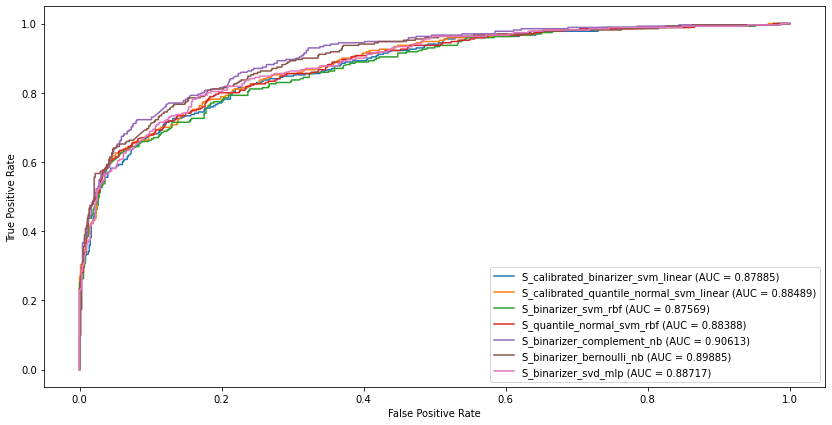

In [31]:
S_estimators = [
    S_calibrated_binarizer_svm_linear,
    S_calibrated_quantile_normal_svm_linear,
    S_binarizer_svm_rbf,
    S_quantile_normal_svm_rbf,
    S_binarizer_complement_nb,
    S_binarizer_bernoulli_nb,
    S_binarizer_svd_mlp,
]


fig, ax = plt.subplots(figsize=(14, 7))

for estimator in S_estimators:
    y_pred = estimator.predict_proba(S_X_test)[:, 1]
    plot_roc_curve(y_test, y_pred, ax, estimator.name)

plt.show()


In [32]:
# SVM

S_quantile_normal_svm_linear_final = GridSearchCV(
    Pipeline(
        [
            ("quantile", QuantileTransformer(output_distribution="normal")),
            ("svm_linear", LinearSVC(class_weight="balanced", random_state=42)),
        ],
        memory=caches,
    ),
    {
        "svm_linear__C": np.logspace(-4, -1, 200),
    },
    **GS
)

S_quantile_normal_svm_linear_final = fit(
    S_quantile_normal_svm_linear_final, S_X_TRAIN, Y
)
S_calibrated_quantile_normal_svm_linear_final = CalibratedClassifierCV(
    S_quantile_normal_svm_linear_final.best_estimator_, cv=10
)
S_calibrated_quantile_normal_svm_linear_final = fit(
    S_calibrated_quantile_normal_svm_linear_final, S_X_TRAIN, Y
)


# Naive Bayes

S_binarizer_complement_nb_final = GridSearchCV(
    Pipeline(
        [
            ("binarizer", Binarizer()),
            ("complement_nb", ComplementNB()),
        ],
        memory=caches,
    ),
    {
        "complement_nb__alpha": np.logspace(-3, 3, 500),
    },
    **GS
)
S_binarizer_complement_nb_final = fit(S_binarizer_complement_nb_final, S_X_TRAIN, Y)


# MLP

S_binarizer_svd_mlp_final = GridSearchCV(
    Pipeline(
        [
            ("binarizer", Binarizer()),
            ("svd", TruncatedSVD(n_components=1500)),
            ("mlp", MLPClassifier(max_iter=500, random_state=42)),
        ],
        memory=caches,
    ),
    {
        "mlp__alpha": np.logspace(-3, 2, 30),
    },
    **GS
)

S_binarizer_svd_mlp_final = fit(S_binarizer_svd_mlp_final, S_X_TRAIN, Y)


FOUND	1 S_quantile_normal_svm_linear_final estimators
LOAD	estimators/S_quantile_normal_svm_linear_final_2021-08-25T12-59-13.joblib

FOUND	1 S_calibrated_quantile_normal_svm_linear_final estimators
LOAD	estimators/S_calibrated_quantile_normal_svm_linear_final_2021-08-25T14-08-57.joblib

FOUND	1 S_binarizer_complement_nb_final estimators
LOAD	estimators/S_binarizer_complement_nb_final_2021-08-25T14-09-23.joblib

FOUND	1 S_binarizer_svd_mlp_final estimators
LOAD	estimators/S_binarizer_svd_mlp_final_2021-08-25T14-09-55.joblib



In [33]:
solution(S_calibrated_quantile_normal_svm_linear_final, S_X_TEST)
solution(S_binarizer_complement_nb_final, S_X_TEST)
solution(S_binarizer_svd_mlp_final, S_X_TEST)


SOL. EXISTS AT 	solutions/S_calibrated_quantile_normal_svm_linear_final_2021-08-25T14-08-57.csv
SOL. EXISTS AT 	solutions/S_binarizer_complement_nb_final_2021-08-25T14-09-23.csv
SOL. EXISTS AT 	solutions/S_binarizer_svd_mlp_final_2021-08-25T14-09-55.csv


In the table below are summarized the more successful model for each type

|type                    | model                        | test score | predicted kaggle score | kaggle score |
| ---------------------- | ---------------------------- | ---------- | ---------------------- | ------------ |
| Support Vector Machine | S_quantile_normal_svm_linear | 0.88489    | 0.90583                | 0.90684      |
| Naive Bayes            | S_binarizer_complement_nb    | 0.90613    | 0.91098                | 0.91384      |
| Multi Layer Perceptron | S_binarizer_svd_mlp          | 0.88717    | 0.90053                | 0.90346      |


---

## Ensambles

In [34]:
S_best_estimators = [
    ("svm", S_calibrated_binarizer_svm_linear),
    ("nb", S_binarizer_complement_nb.best_estimator_),
    ("mpl", S_binarizer_svd_mlp.best_estimator_),
]


In [35]:
S_stacking = GridSearchCV(
    StackingClassifier(
        S_best_estimators,
        LogisticRegression(class_weight="balanced", random_state=42),
        cv=10,
        n_jobs=-1,
        stack_method="predict_proba",
    ),
    {
        "final_estimator__C": np.logspace(-3, 2, 40),
    },
    **GS
)


S_stacking = fit(S_stacking, S_X_train, y_train)
S_stacking


FOUND	1 S_stacking estimators
LOAD	estimators/S_stacking_2021-08-26T14-56-40.joblib



GridSearchCV(cv=10,
             estimator=StackingClassifier(cv=10,
                                          estimators=[('svm',
                                                       CalibratedClassifierCV(base_estimator=Pipeline(memory=Memory(location=temp),
                                                                                                      steps=[('binarizer',
                                                                                                              Binarizer()),
                                                                                                             ('svm_linear',
                                                                                                              LinearSVC(C=0.04768611697714469,
                                                                                                                        class_weight='balanced',
                                                                              

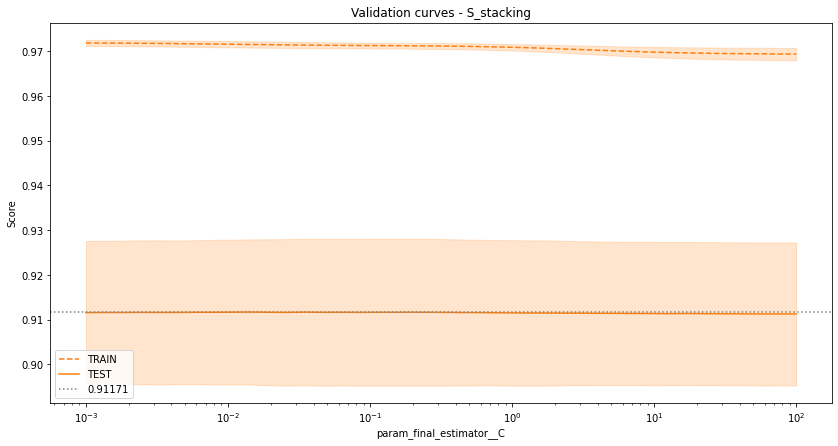

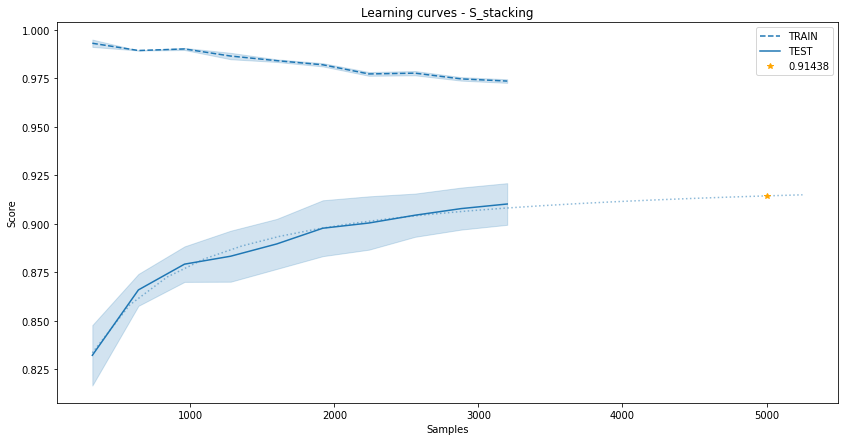

In [36]:
plot_validation_curves(S_stacking, "param_final_estimator__C")
plot_learning_curves(S_stacking, S_X_train, y_train, len(train_target))


In [37]:
S_voting = VotingClassifier(S_best_estimators, voting="soft", n_jobs=-1)

S_voting = fit(S_voting, S_X_train, y_train)
S_voting


FOUND	1 S_voting estimators
LOAD	estimators/S_voting_2021-08-26T22-15-57.joblib



VotingClassifier(estimators=[('svm',
                              CalibratedClassifierCV(base_estimator=Pipeline(memory=Memory(location=temp),
                                                                             steps=[('binarizer',
                                                                                     Binarizer()),
                                                                                    ('svm_linear',
                                                                                     LinearSVC(C=0.04768611697714469,
                                                                                               class_weight='balanced',
                                                                                               max_iter=5000,
                                                                                               random_state=42))]),
                                                     cv=10)),
                             ('nb'

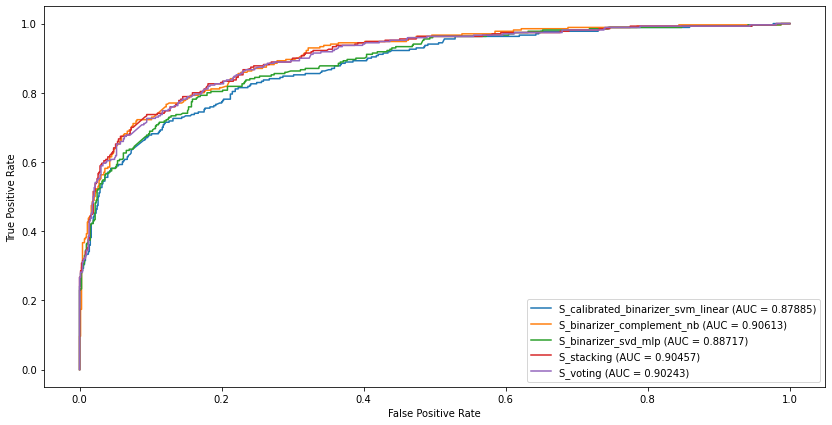

In [38]:
S_estimators = [
    S_calibrated_binarizer_svm_linear,
    S_binarizer_complement_nb,
    S_binarizer_svd_mlp,
    S_stacking,
    S_voting,
]


fig, ax = plt.subplots(figsize=(14, 7))

for estimator in S_estimators:
    y_pred = estimator.predict_proba(S_X_test)[:, 1]
    plot_roc_curve(y_test, y_pred, ax, estimator.name)

plt.show()


-----

# Feature - Text

In [39]:
REGEX = [
    re.compile(r"[\w.-]+@[\w.-]+"),  # emails
    re.compile(r"(http|www)[^\s]+"),  # urls
    re.compile(r"[\d]{2,4}[ -/:]*[\d]{2,4}([ -/:]*[\d]{2,4})?"),  # dates
    re.compile("<.*?>"),  # html tags
    re.compile("<!--.*?-->"),  # html comments
    re.compile(r"&gt;"),  # html unescaped
]


def clean_with_regex(text):
    for regex in REGEX:
        text = regex.sub("", text)
    return re.sub(r"[\s]+", " ", text).strip()


def text(data):
    return [
        clean_with_regex(group.body.str.cat(sep=" "))
        for _, group in data.groupby("author")
    ]


T_TRAIN = text(train_data)
T_TEST = text(test_data)

# Split T_TRAIN in T_train and T_test. test will be used to evaluate the performance.
T_train, T_test, y_train, y_test = train_test_split(
    T_TRAIN, Y, test_size=0.20, random_state=42, stratify=Y
)


In [40]:
T_complement_nb = GridSearchCV(
    Pipeline(
        [
            ("vectorizer", CountVectorizer(binary=True)),
            ("tfidf", TfidfTransformer()),
            ("nb", ComplementNB()),
        ],
        memory=caches,
    ),
    {
        "vectorizer__max_features": (None, 20000, 50000, 75000, 90000),
        "vectorizer__stop_words": ("english", None),
        "vectorizer__max_df": (0.8, 0.9, 1.0),
        "tfidf__use_idf": (True, False),
        "nb__alpha": np.logspace(-3, 1, 50),
    },
    n_jobs=-1,
    scoring="roc_auc",
    verbose=1,
)

T_complement_nb = fit(T_complement_nb, T_train, y_train)
T_complement_nb


FOUND	1 T_complement_nb estimators
LOAD	estimators/T_complement_nb_2021-08-28T14-58-09.joblib



GridSearchCV(estimator=Pipeline(memory=Memory(location=../temp),
                                steps=[('vectorizer',
                                        CountVectorizer(binary=True)),
                                       ('tfidf', TfidfTransformer()),
                                       ('nb', ComplementNB())]),
             n_jobs=-1,
             param_grid={'nb__alpha': array([1.00000000e-03, 1.20679264e-03, 1.45634848e-03, 1.75751062e-03,
       2.12095089e-03, 2.55954792e-03, 3.08884360e-03, 3.72759372e-03,
       4.49843267e-03, 5.4286...
       8.68511374e-01, 1.04811313e+00, 1.26485522e+00, 1.52641797e+00,
       1.84206997e+00, 2.22299648e+00, 2.68269580e+00, 3.23745754e+00,
       3.90693994e+00, 4.71486636e+00, 5.68986603e+00, 6.86648845e+00,
       8.28642773e+00, 1.00000000e+01]),
                         'tfidf__use_idf': (True, False),
                         'vectorizer__max_df': (0.8, 0.9, 1.0),
                         'vectorizer__max_features': (None, 20

In [41]:
print(T_complement_nb.best_params_)
print(T_complement_nb.best_score_)


{'nb__alpha': 0.02442053094548651, 'tfidf__use_idf': False, 'vectorizer__max_df': 0.9, 'vectorizer__max_features': 50000, 'vectorizer__stop_words': None}
0.8781594699620345


## More sophisticated preprocessing

In [42]:
nlp = en_core_web_lg.load(exclude=["parser", "ner"])


def text2token(data):
    path = working_path / "embeddings" / f"{var2str(data)}.txt"

    if path.is_file():
        print(f"LOAD TOKENS - {path}")
        with open(path) as f:
            tokens = f.read().splitlines()
    else:
        print(f"GENERATING TOKENS - {path}")
        tokens = [
            ",".join(
                [
                    token.lemma_
                    for doc in nlp.pipe(group.body)
                    for token in doc
                    if not (
                        token.is_punct | token.is_space | token.is_stop | token.is_oov
                    )
                ]
            )
            for _, group in tqdm(data.groupby("author"))
        ]
        with open(path, "w") as f:
            for author in tokens:
                f.write(f"{author}\n")

    return tokens


T_TRAIN_token = text2token(train_data)
T_TEST_token = text2token(test_data)


LOAD TOKENS - embeddings/train_data.txt
LOAD TOKENS - embeddings/test_data.txt
